# Importance of this problem
Nowadays, in our modern society, we find ourselves rarely using cash. Our money transactions are more likely to be digital, i.e. credit cards, bank transfers, app transfers, etc. It is very effortless and convenient to carry out all these tasks in the comfort of our home. However, this advance in technology can also generate great discomfort. Thieves are getting more creative, and we see that digital financial fraud is increasing day by day, minute by minute. Hence, staying ahead of these con artists is essential. One way of doing this is to generate accurate models that can predict whether a transaction is fraudulent or not.

To tackle this problem, I used Machine Learning to predict and detect digital fraud. During this analysis I will try to answer questions like:

- What is the most fraudulent transaction type?
- Is there a most common time of day fraudulent activities are carried out?

Let's get started!

# Dataset source
This data set ("Synthetic financial datasets for fraud detection") was obtained from Kaggle (https://www.kaggle.com/datasets/ealaxi/paysim1/data)

This is a synthetic financial dataset that "simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country".

# Dataset description
**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction.

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

# 1) Load dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go



In [ ]:
# Load dataset:
from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Capstone II: Supervised learning/Synthetic Financial Datasets For Fraud Detection.csv')

df.info()
df.head()

Mounted at /content/gdrive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# 2) Data cleaning and exploration
Handling missing values, outliers, etc




In [ ]:
df.isnull().sum().sort_values(ascending=False)/len(df)

step              0.0
type              0.0
amount            0.0
nameOrig          0.0
oldbalanceOrg     0.0
newbalanceOrig    0.0
nameDest          0.0
oldbalanceDest    0.0
newbalanceDest    0.0
isFraud           0.0
isFlaggedFraud    0.0
dtype: float64

Looks like there are no missing values in the dataset. That's great! But remember this is a synthetic dataset!

However, if we were to find missing values this is how we can handle them:

- Disregard rows (tricky! we could be losing a lot of data).
- Fill these values with unharmful values. We could use the mean, median, interpolate, etc.

Now, let's check some stats:

In [ ]:
df.describe().round(2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6.362620e+06,6.362620e+06,6362620.00,6362620.0
mean,243.40,179861.90,833883.10,855113.67,1.100702e+06,1.224996e+06,0.00,0.0
std,142.33,603858.23,2888242.67,2924048.50,3.399180e+06,3.674129e+06,0.04,0.0
min,1.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
25%,156.00,13389.57,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
50%,239.00,74871.94,14208.00,0.00,1.327057e+05,2.146614e+05,0.00,0.0
75%,335.00,208721.48,107315.18,144258.41,9.430367e+05,1.111909e+06,0.00,0.0
max,743.00,92445516.64,59585040.37,49585040.37,3.560159e+08,3.561793e+08,1.00,1.0


Let's look at the correlation matrix, just to have an idea of the relationships between variables, and also to complement the stats above.

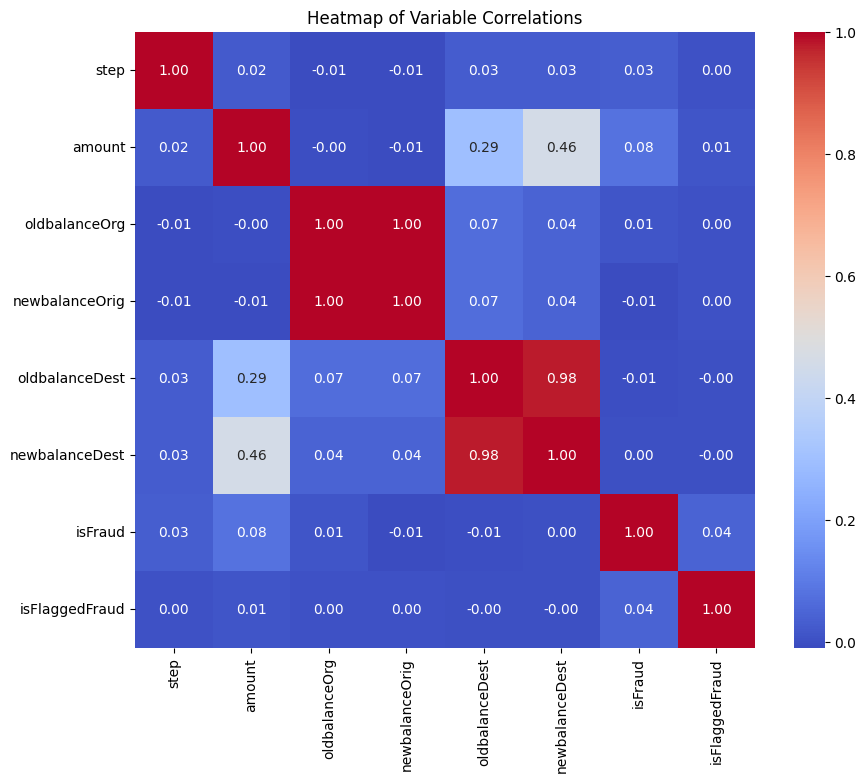

In [ ]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Variable Correlations')
plt.show()


We can see that the highest correlations come from old and new balances, as expected.

## **Let's analyze the target variable `isFraud`**

In [ ]:
grouped_stats = df.groupby('isFraud')['amount'].agg(['mean', 'median', 'std'])
print(grouped_stats)

                 mean     median           std
isFraud                                       
0        1.781970e+05   74684.72  5.962370e+05
1        1.467967e+06  441423.44  2.404253e+06


We can see that the amount that gets transferred and it's flagged as fraud is one order of magnitude larger than the ones that don't get flagged as fraud.

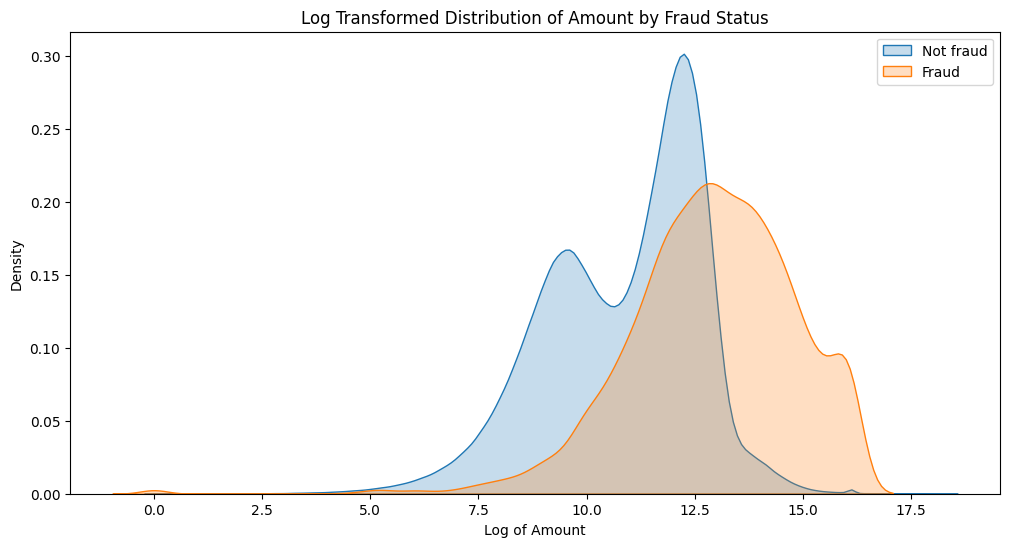

In [ ]:
df['log_amount'] = np.log1p(df['amount'])
plt.figure(figsize=(12, 6))
sns.kdeplot(df[df['isFraud'] == 0]['log_amount'], label='Not fraud', fill=True)
sns.kdeplot(df[df['isFraud'] == 1]['log_amount'], label='Fraud', fill=True)

plt.title('Log Transformed Distribution of Amount by Fraud Status')
plt.xlabel('Log of Amount')
plt.ylabel('Density')
plt.legend()
plt.show()

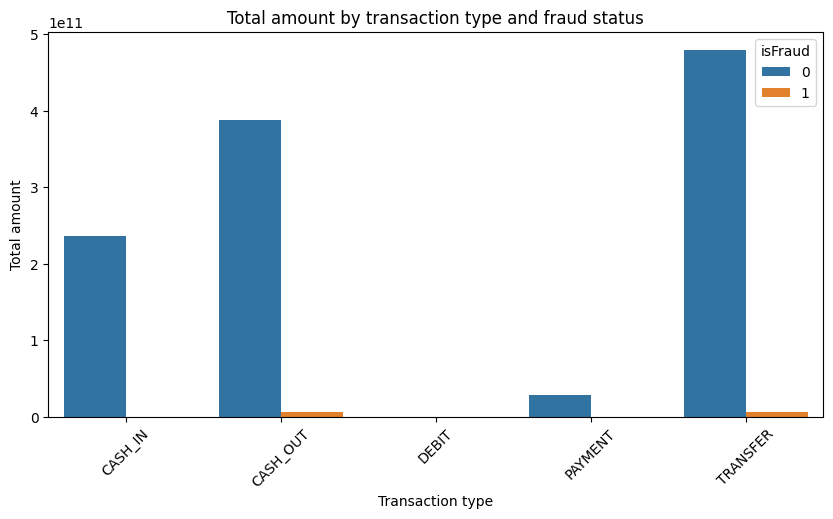

In [ ]:
amount_by_type = df.groupby(['type', 'isFraud'])['amount'].sum().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(x='type', y='amount', hue='isFraud', data = amount_by_type)
plt.title('Total amount by transaction type and fraud status')
plt.xlabel('Transaction type')
plt.ylabel('Total amount')
plt.xticks(rotation=45)
plt.show()

It looks like `cash out` and `transfer` transaction types are often flagged as potential fraudulent transaction.

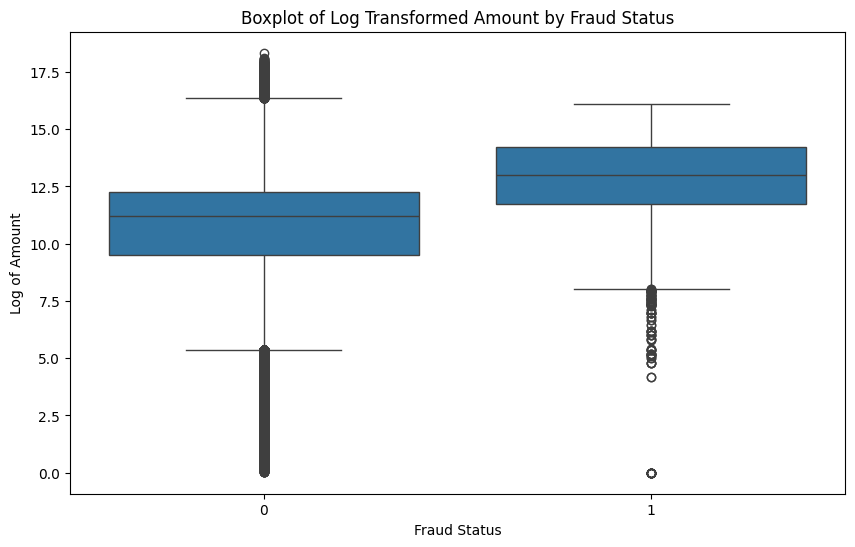

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='log_amount', data=df)
plt.title('Boxplot of Log Transformed Amount by Fraud Status')
plt.xlabel('Fraud Status')
plt.ylabel('Log of Amount')
plt.show()

The boxplot visually compares the distribution of log-transformed transaction amounts across fraud status. This method offers insights into how transaction amounts differ in cases suspected of fraud compared to those not suspected. The plot suggests that transactions involving fraud may have some outliers, indicating unusually small amounts compared to typical transactions.

In [ ]:
fraud_counts = df['isFraud'].value_counts()

In [ ]:
fraud_counts

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [ ]:
#px.pie(df, values = fraud_counts, names = ['Not Fraud','Fraud'],hole = 0.2)
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=df['isFraud'].value_counts())])
fig.show()



We can see how imbalanced this data set is. We'll make it more even, since that's a condition for ML.

Randomly remove entries from the majority class (non-fraudulent transactions) to match the minority class' count.

We need to be careful since this might lead to a significant loss of data.

In [ ]:
from sklearn.utils import resample
df_majority = df[df['isFraud'] == 0]
df_minority = df[df['isFraud'] == 1]

# Downsample the majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,  # sample without replacement
                                   n_samples=len(df_minority),  # to match minority class
                                   random_state=123)  # reproducible results

df_balanced = pd.concat([df_majority_downsampled, df_minority])
print(df_balanced['isFraud'].value_counts())


isFraud
0    8213
1    8213
Name: count, dtype: int64


In [ ]:
df_new = df_balanced.copy()

In [ ]:
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=df_new['isFraud'].value_counts())])
fig.show()

**Now we have a balanced dataset**

In [ ]:
df_new

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,log_amount
5844077,402,PAYMENT,3646.13,C388544972,20532.00,16885.87,M160288501,0.00,0.00,0,0,8.201696
6359076,715,CASH_OUT,150708.06,C1172797450,2562.00,0.00,C434060534,544897.92,695605.98,0,0,11.923107
5554125,383,PAYMENT,9738.36,C944342245,0.00,0.00,M1240838729,0.00,0.00,0,0,9.183931
6121974,540,PAYMENT,1533.54,C1474765044,49852.00,48318.46,M1365306187,0.00,0.00,0,0,7.335986
2434094,203,PAYMENT,27865.80,C1628165387,0.00,0.00,M66521494,0.00,0.00,0,0,10.235191
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,12.735768
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,15.657870
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,15.657870
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,13.652996


##**Let's check the variable `type` - What is the most fraudulent transaction?**

In [ ]:
# checking variable `type`
df_new["type"].unique()

array(['PAYMENT', 'CASH_OUT', 'CASH_IN', 'TRANSFER', 'DEBIT'],
      dtype=object)

In [ ]:
type = df_new["type"].value_counts()
transaction = type.index
quantity = type.values


In [ ]:
px.pie(df_new, values = quantity, names = transaction,hole = 0.2,title = "Pie chart of transaction type")


In [ ]:
pd.crosstab(df_new['type'], df_new['isFraud'])

isFraud,0,1
type,,
CASH_IN,1805,0
CASH_OUT,2843,4116
DEBIT,37,0
PAYMENT,2831,0
TRANSFER,697,4097


In [ ]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df_new.loc[df_new.isFraud == 1].type.drop_duplicates().values)))

dfFraudTransfer = df_new.loc[(df_new.isFraud == 1) & (df_new.type == 'TRANSFER')]
dfFraudCashout = df_new.loc[(df_new.isFraud == 1) & (df_new.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer)))

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout)))


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


From the table, we can see that `transfers` and `chash out` are the two fraudulent transactions.

##**Let's check the variable `step` - What time of the day are fraudulent transactions occurring?**

If we recall, "`step` maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation)".

We want to convert these step values to 24 hours.

In [ ]:
df_new['Hour'] = df_new['step'] % 24

In [ ]:
df_new

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,log_amount,Hour
5844077,402,PAYMENT,3646.13,C388544972,20532.00,16885.87,M160288501,0.00,0.00,0,0,8.201696,18
6359076,715,CASH_OUT,150708.06,C1172797450,2562.00,0.00,C434060534,544897.92,695605.98,0,0,11.923107,19
5554125,383,PAYMENT,9738.36,C944342245,0.00,0.00,M1240838729,0.00,0.00,0,0,9.183931,23
6121974,540,PAYMENT,1533.54,C1474765044,49852.00,48318.46,M1365306187,0.00,0.00,0,0,7.335986,12
2434094,203,PAYMENT,27865.80,C1628165387,0.00,0.00,M66521494,0.00,0.00,0,0,10.235191,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,12.735768,23
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,15.657870,23
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,15.657870,23
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,13.652996,23


Checking the correlation matrix again with these new variables

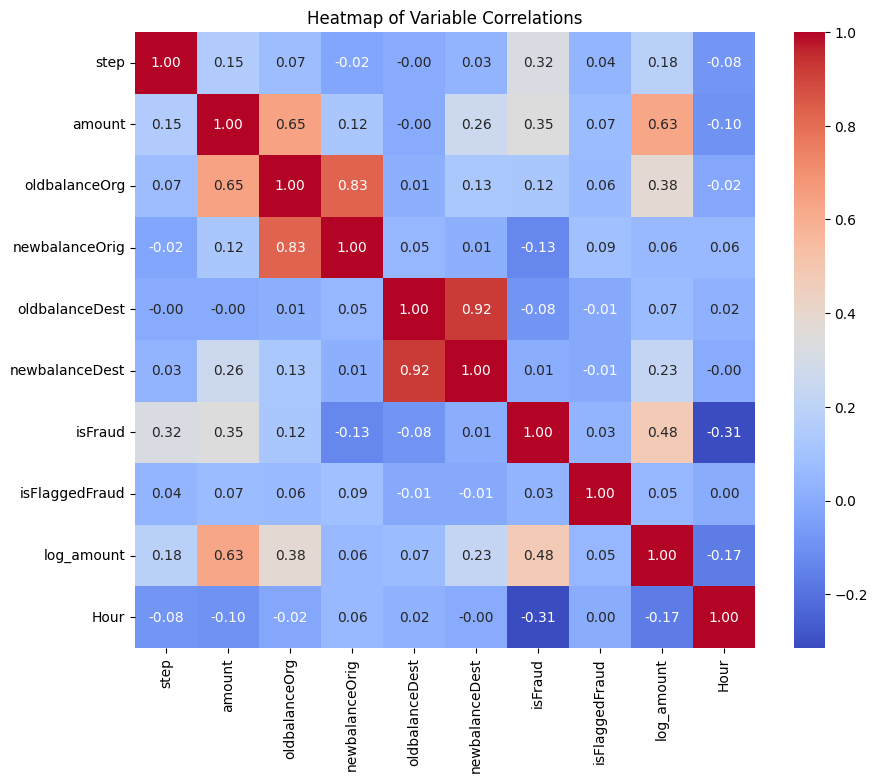

In [ ]:
corr = df_new.corr(numeric_only=True)
plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Variable Correlations')
plt.show()

Now we see and increase in correlation between `isFraud` and `log_amount` and `Hour`.

In [ ]:
corr

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,log_amount,Hour
step,1.000000,0.149492,0.072695,-0.024128,-0.004070,0.030441,0.322185,0.037267,0.180549,-0.081462
amount,0.149492,1.000000,0.645471,0.122881,-0.002616,0.259960,0.347815,0.068048,0.629529,-0.095849
oldbalanceOrg,0.072695,0.645471,1.000000,0.826687,0.013751,0.127222,0.122817,0.062647,0.379064,-0.017558
newbalanceOrig,-0.024128,0.122881,0.826687,1.000000,0.047301,0.010804,-0.133414,0.089691,0.055799,0.058151
oldbalanceDest,-0.004070,-0.002616,0.013751,0.047301,1.000000,0.921093,-0.084953,-0.007812,0.066313,0.021601
newbalanceDest,0.030441,0.259960,0.127222,0.010804,0.921093,1.000000,0.007316,-0.010679,0.225714,-0.004815
isFraud,0.322185,0.347815,0.122817,-0.133414,-0.084953,0.007316,1.000000,0.031225,0.479726,-0.314476
isFlaggedFraud,0.037267,0.068048,0.062647,0.089691,-0.007812,-0.010679,0.031225,1.000000,0.045211,0.003191
log_amount,0.180549,0.629529,0.379064,0.055799,0.066313,0.225714,0.479726,0.045211,1.000000,-0.166508
Hour,-0.081462,-0.095849,-0.017558,0.058151,0.021601,-0.004815,-0.314476,0.003191,-0.166508,1.000000


Next, we will plot the transaction numbers (fraudulent and non-fraudulent) vs. time of day:

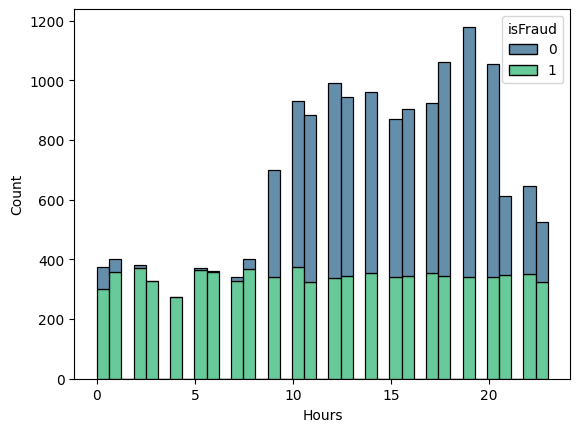

In [ ]:
ax = sns.histplot(data= df_new, x='Hour', hue='isFraud', multiple='stack', palette='viridis')
ax.set(xlabel='Hours', ylabel='Count')
plt.show()

Let's take this a step further and calculate the rate of fraudulent transactions with time.

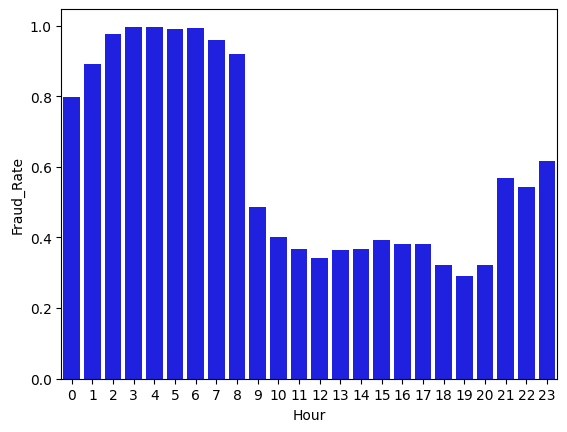

In [ ]:
hour_fraud = pd.concat([df_new.groupby("Hour")["isFraud"].sum(),df_new.groupby("Hour")["isFraud"].count()],axis=1)
hour_fraud.columns = ["Fraud_Num","Transactions_Num"]
hour_fraud["Fraud_Rate"] = hour_fraud.Fraud_Num/hour_fraud.Transactions_Num
sns.barplot(x=hour_fraud.index,y=hour_fraud.Fraud_Rate, color = 'blue')
plt.show()

From this plot we can see that between hours 21 and 8am is when most fraudulent transactions occur, with the highest between 0am and 8am.

In [ ]:
hour_fraud

,Fraud_Num,Transactions_Num,Fraud_Rate
Hour,,,
0,300,376,0.797872
1,358,401,0.892768
2,372,381,0.976378
3,326,327,0.996942
4,274,275,0.996364
5,366,370,0.989189
6,358,360,0.994444
7,328,342,0.959064
8,368,400,0.920000


## **Let's prep the data for ML**

Let's get dummies for variable type and then encode variables `nameOrig` and `nameDest`.

In [ ]:
df_new

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Hour
5844077,402,PAYMENT,3646.13,C388544972,20532.00,16885.87,M160288501,0.00,0.00,0,0,18
6359076,715,CASH_OUT,150708.06,C1172797450,2562.00,0.00,C434060534,544897.92,695605.98,0,0,19
5554125,383,PAYMENT,9738.36,C944342245,0.00,0.00,M1240838729,0.00,0.00,0,0,23
6121974,540,PAYMENT,1533.54,C1474765044,49852.00,48318.46,M1365306187,0.00,0.00,0,0,12
2434094,203,PAYMENT,27865.80,C1628165387,0.00,0.00,M66521494,0.00,0.00,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,23
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,23
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,23
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,23


In [ ]:
df_new = df_new.drop(['isFlaggedFraud'],axis = 1)

In [ ]:
df_new = pd.concat([df_new,pd.get_dummies(df_new.type, prefix="type", drop_first=True).astype(int)], axis=1)
df_new = df_new.drop(['type'],axis = 1)

In [ ]:
# Encode variables nameOrig and nameDest:

from sklearn.preprocessing import LabelEncoder
import pandas as pd

def convert_objects_to_int(df):
    label_encoders = {}
    for column in df.select_dtypes(include=['object']):
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

    return df, label_encoders
df_new_reduced, encoders = convert_objects_to_int(df_new)

In [ ]:
df_new_reduced

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Hour,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
5844077,402,3646.13,11194,20532.00,16885.87,14282,0.00,0.00,0,0,18,0,0,1,0
6359076,715,150708.06,1471,2562.00,0.00,9462,544897.92,695605.98,0,0,19,1,0,0,0
5554125,383,9738.36,15919,0.00,0.00,13751,0.00,0.00,0,0,23,0,0,1,0
6121974,540,1533.54,4049,49852.00,48318.46,13923,0.00,0.00,0,0,12,0,0,1,0
2434094,203,27865.80,5396,0.00,0.00,15768,0.00,0.00,0,0,11,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,14576,339682.13,0.00,11897,0.00,339682.13,1,0,23,1,0,0,0
6362616,743,6311409.28,4553,6311409.28,0.00,6073,0.00,0.00,1,0,23,0,0,0,1
6362617,743,6311409.28,1381,6311409.28,0.00,2424,68488.84,6379898.11,1,0,23,1,0,0,0
6362618,743,850002.52,5866,850002.52,0.00,7390,0.00,0.00,1,0,23,0,0,0,1


Now we are ready to build ML models for fraud detection.

# 3) Model building

Choosing appropriate ML models for fraud detection.

## Model 1: Logistic Regression (baseline)

For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones. For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
‘liblinear’ is limited to one-versus-rest schemes. ‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty ‘liblinear’ and ‘saga’ also handle L1 penalty ‘saga’ also supports ‘elasticnet' penalty ‘liblinear’ does not handle no penalty

Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.

In [ ]:
df_new_reduced.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,log_amount,Hour,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
5844077,402,3646.13,11194,20532.0,16885.87,14282,0.00,0.00,0,0,8.201696,18,0,0,1,0
6359076,715,150708.06,1471,2562.0,0.00,9462,544897.92,695605.98,0,0,11.923107,19,1,0,0,0
5554125,383,9738.36,15919,0.0,0.00,13751,0.00,0.00,0,0,9.183931,23,0,0,1,0
6121974,540,1533.54,4049,49852.0,48318.46,13923,0.00,0.00,0,0,7.335986,12,0,0,1,0
2434094,203,27865.80,5396,0.0,0.00,15768,0.00,0.00,0,0,10.235191,11,0,0,1,0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_squared_error

X = df_new_reduced.drop('isFraud', axis=1)
y = df_new_reduced['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 465)

# mean=0 and standard deviation=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  logistic regression model with adjusted regularization
logreg_model = LogisticRegression(penalty='l2', C=0.05)  #  adjust 'C' for regularization strength
logreg_model.fit(X_train_scaled, y_train)

train_accuracy = logreg_model.score(X_train_scaled, y_train)
test_accuracy = logreg_model.score(X_test_scaled, y_test)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

coefficients = logreg_model.coef_
print("Coefficients:", coefficients)

y_prob = logreg_model.predict_proba(X_test_scaled)[:, 1]

y_pred_ms= (y_prob >= 0.5).astype(int) #######

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


Training Accuracy: 0.8770928462709284
Test Accuracy: 0.8855751673767498
Coefficients: [[ 0.59572869  0.31838165 -0.01513463  3.96984747 -2.97839235 -0.01802937
   0.31144168 -0.84376032  0.07298482 -0.60498166  1.74785387 -0.08386096
  -0.83373564  2.13667367]]


The coefficients in a logistic regression model represent the log-odds of the positive class (in our case, "isFraud") with respect to the corresponding feature. The sign of each coefficient (positive or negative) indicates the direction of influence, and the magnitude indicates the strength of that influence.

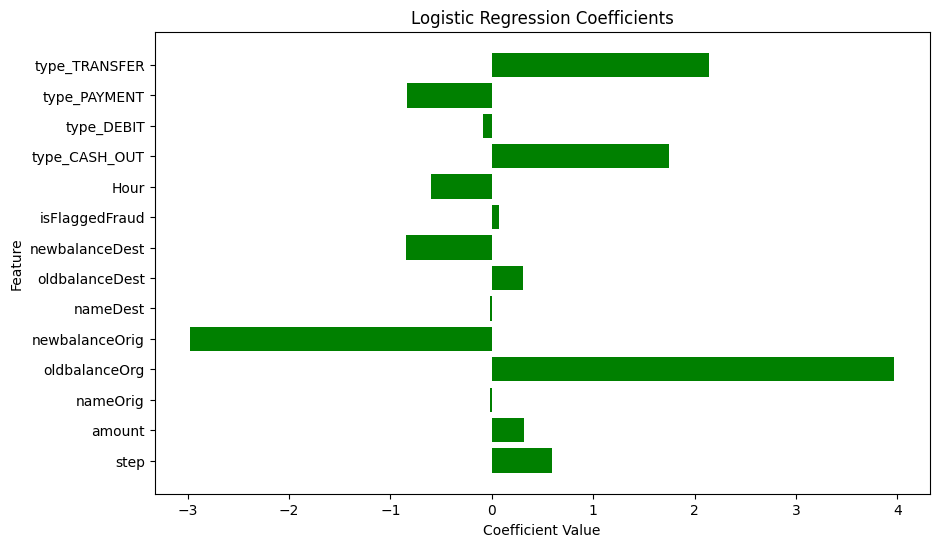

In [ ]:
# Let's look at the coefficients
coefficients = logreg_model.coef_[0]
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients, color='g')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = logreg_model.predict(X_test_scaled)
confusion = confusion_matrix(y_test, predictions, labels=[1, 0])
print(confusion)

[[1493  148]
 [ 228 1417]]


In [ ]:
# confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Given a scikit-learn confusion matrix (CM), make a nice plot.

    Arguments
    ---------
    cm:           Confusion matrix from sklearn.metrics.confusion_matrix

    target_names: Given classification classes, such as [0, 1, 2]
                  The class names, for example, ['high', 'medium', 'low']

    title:        The text to display at the top of the matrix

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  `plt.get_cmap('jet')` or `plt.cm.Blues`

    normalize:    If `False`, plot the raw numbers
                  If `True`, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # Confusion matrix created by
                                                              # `sklearn.metrics.confusion_matrix`
                          normalize    = True,                # Show proportions
                          target_names = y_labels_vals,       # List of names of the classes
                          title        = best_estimator_name) # Title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

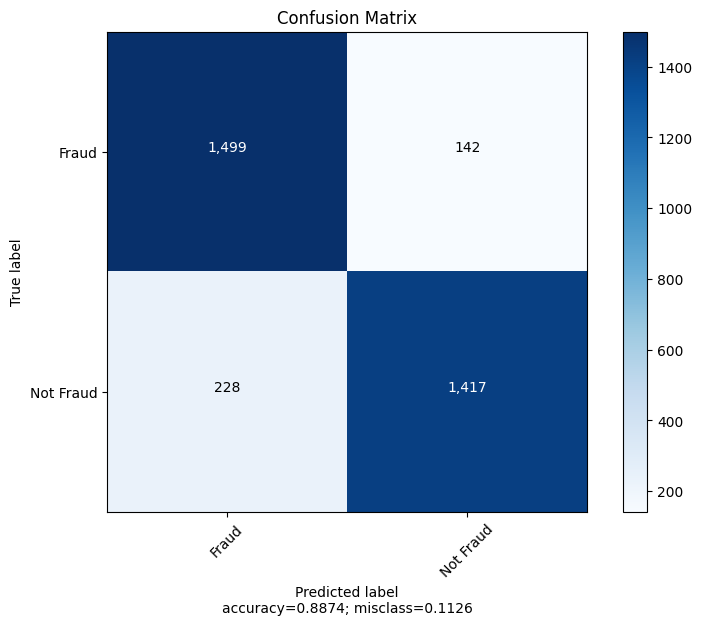

In [ ]:
plot_confusion_matrix(cm=confusion, target_names = ['Fraud', 'Not Fraud'], title = 'Confusion Matrix',normalize=False)


From the confusion matrix we can see that our Logistic Regression model has 88% accuracy in predicting a true positive and a true negative.

In [ ]:
# Let's calculate metrics:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
fbeta_precision = fbeta_score(y_test, predictions, beta=0.5)
fbeta_recall = fbeta_score(y_test, predictions, beta=2)

print('Accuracy score: {:.2f}'.format(accuracy))
print('Precision score: {:.2f}'.format(precision))
print('Recall score: {:.2f}'.format(recall))
print('F1 score: {:.2f}'.format(f1))
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))

Accuracy score: 0.89
Precision score: 0.87
Recall score: 0.91
F1 score: 0.89
Fbeta score favoring precision: 0.88
FBeta score favoring recall: 0.90


In [ ]:
report = classification_report(y_test, predictions, target_names=['Not Fraud', 'Fraud'])
print(report)

              precision    recall  f1-score   support

   Not Fraud       0.91      0.86      0.88      1645
       Fraud       0.87      0.91      0.89      1641

    accuracy                           0.89      3286
   macro avg       0.89      0.89      0.89      3286
weighted avg       0.89      0.89      0.89      3286



In [ ]:
mse = mean_squared_error(y_test, y_pred_ms)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.11442483262325015


In our case, the mean squared error is 0.11. This value tells us how much the model's predicted probabilities differ from the actual outcomes.

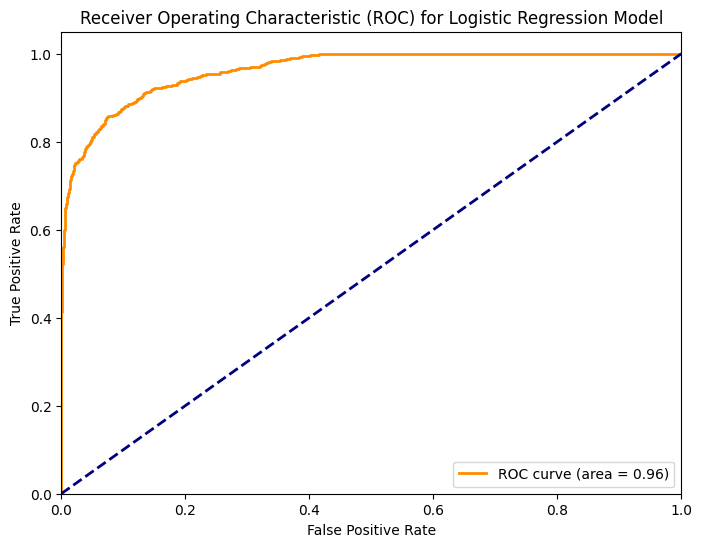

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Logistic Regression Model')
plt.legend(loc="lower right")
plt.show()


A score of 0.96 indicates that our model has strong discriminatory power and is effective at distinguishing between instances of fraud (positive class) and  not fraud (negative class) in our dataset.

In [ ]:
# Another way of calculating model accuracy
from sklearn.model_selection import cross_val_score

print("Test Accuracy: {}".format(cross_val_score(logreg_model, X_train_scaled, y_train, cv=10, scoring ='accuracy').mean()))

Test Accuracy: 0.8766362252663622


## Model 2: KNN Classifier (non-linear classifier)

This classifier works by comparing each data point to its  𝑘  nearest neighbors, where  𝑘  is some arbitrary integer. The data point will be classified as belonging to the most populous group among the five neighbors.

Technically, this algorithm doesn't "learn" the way that the others do. Rather, it looks for similarities between objects. KNN makes no assumptions about the data, and doesn't require quite as much data preparation as other algorithms. That is, it is not affected by outliers as much as other algorithms. However, it is a computationally expensive algorithm, and requires memory to hold all the data. As a result, as datasets grow, memory requirements grow too.

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, mean_squared_error

X = df_new_reduced.drop('isFraud', axis=1)
y = df_new_reduced['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 465)

# mean=0 and standard deviation=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors = 10,weights='distance')

knn.fit(X_train_scaled, y_train)

#knn_10_score = knn.score(X_test_scaled, y_test)
knn_10_predictions = knn.predict(X_test_scaled)

#print('Accuracy of KNN (k = 10): {:.3f}'.format(knn_10_score))

train_accuracy_knn = knn.score(X_train_scaled, y_train)
test_accuracy_knn = knn.score(X_test_scaled, y_test)

print("Training Accuracy:", train_accuracy_knn)
print("Test Accuracy:", test_accuracy_knn)

Training Accuracy: 1.0
Test Accuracy: 0.9062690200852099


In [ ]:
mse_knn = mean_squared_error(y_test, knn_10_predictions)
print("Mean Squared Error (MSE):", mse_knn)

Mean Squared Error (MSE): 0.09373097991479001


We can see a slight improvement in the accuracy, compared to the logistic regression model.

In [ ]:
# Validating KNN:
from sklearn.model_selection import cross_val_score

score = cross_val_score(knn, X_train_scaled, y_train, cv = 5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.90 (+/- 0.00)


## Model 3: Random Forest (non-linear classifier)

The random forest classifier is built on a collection of decision trees. Because any one tree may be overfitting the data or may not give optimal results, random forest generates many trees and compares the results from many trees to make a final decision. This is usually a better choice than just a single decision tree.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, mean_squared_error

X = df_new_reduced.drop('isFraud', axis=1)
y = df_new_reduced['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 465)

# mean=0 and standard deviation=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_model.fit(X_train_scaled, y_train)

train_accuracy_rf = rfc_model.score(X_train_scaled, y_train)
test_accuracy_rf = rfc_model.score(X_test_scaled, y_test)

print("Random Forest Training Accuracy:", train_accuracy_rf)
print("Random Forest Test Accuracy:", test_accuracy_rf)

y_prob_rf = rfc_model.predict_proba(X_test_scaled)[:, 1]
y_pred_rf = (y_prob_rf >= 0.5).astype(int)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print("Random Forest ROC AUC:", roc_auc_rf)

#print(f'{cross_val_score(rfc, X, Y, cv=10)}\n')

Random Forest Training Accuracy: 1.0
Random Forest Test Accuracy: 0.9911746804625685
Random Forest ROC AUC: 0.9994880429125246


In [ ]:
# Another way of calculating model accuracy
from sklearn.model_selection import cross_val_score

print("Test Accuracy: {}".format(cross_val_score(rfc_model, X_train_scaled, y_train, cv=10, scoring ='accuracy').mean()))

Test Accuracy: 0.9890410958904109


In [ ]:
"""initial_number_of_data_points = len(X_train_scaled)


def get_unique(X_matrix, y_vector):
    Xy = list(set(list(zip([tuple(x) for x in X_matrix], y_vector))))
    X_matrix = [list(l[0]) for l in Xy]
    y_vector = [l[1] for l in Xy]
    return X_matrix, y_vector


x, y = get_unique(X_train_scaled, y_train)
data_points_removed = initial_number_of_data_points - len(x)
print("Number of duplicates removed:", data_points_removed )

A training accuracy of 100% seems pretty suspicious, it could mean that the model became too used to the training data (overfitting). However, an accuracy of 100% for Random Forest models is somewhat "normal". We can try tuning the hyperparameters to see if we get a different result.

In [ ]:
# hyperparameter tuning:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, mean_squared_error

X = df_new_reduced.drop('isFraud', axis=1)
y = df_new_reduced['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 465)

# mean=0 and standard deviation=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 4, 8],
    'min_samples_split': [2, 5, 10]
}

# Create the Random Forest classifier
rfc_model = RandomForestClassifier(random_state=42)

# GridSearchCV performs hyperparameter tuning using cross-validation
grid_search = GridSearchCV(estimator=rfc_model, param_grid=param_grid, cv=5, scoring='roc_auc')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best estimator and its parameters
best_rfc_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

train_accuracy_rfc = best_rfc_model.score(X_train_scaled, y_train)
test_accuracy_rfc = best_rfc_model.score(X_test_scaled, y_test)

print("Random Forest Training Accuracy:", train_accuracy_rf)
print("Random Forest Test Accuracy:", test_accuracy_rf)

y_prob_rfc = best_rfc_model.predict_proba(X_test_scaled)[:, 1]
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, y_prob_rfc)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)
print("Random Forest ROC AUC:", roc_auc_rfc)

Best Hyperparameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 300}
Random Forest Training Accuracy: 1.0
Random Forest Test Accuracy: 0.9911746804625685
Random Forest ROC AUC: 0.9986656516432082


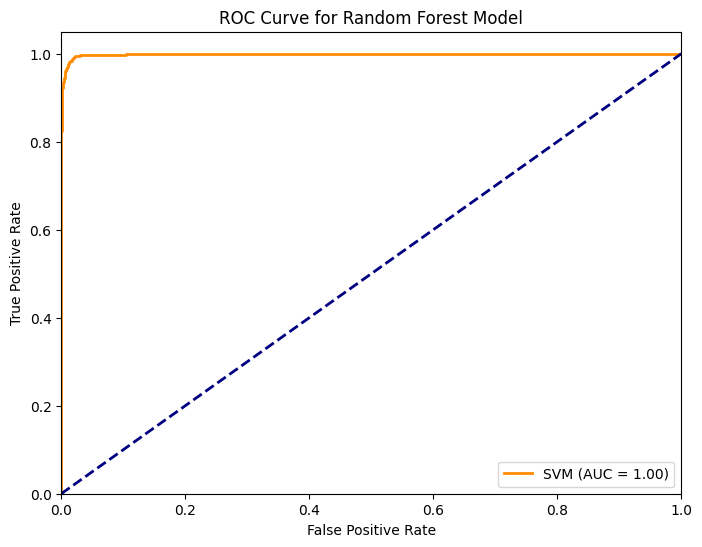

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_rfc, tpr_rfc, color='darkorange', lw=2, label='SVM (AUC = {:.2f})'.format(roc_auc_rfc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Model')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = best_rfc_model.predict(X_test_scaled)
confusion = confusion_matrix(y_test, predictions, labels=[1, 0])
print(confusion)

[[1629   12]
 [  35 1610]]


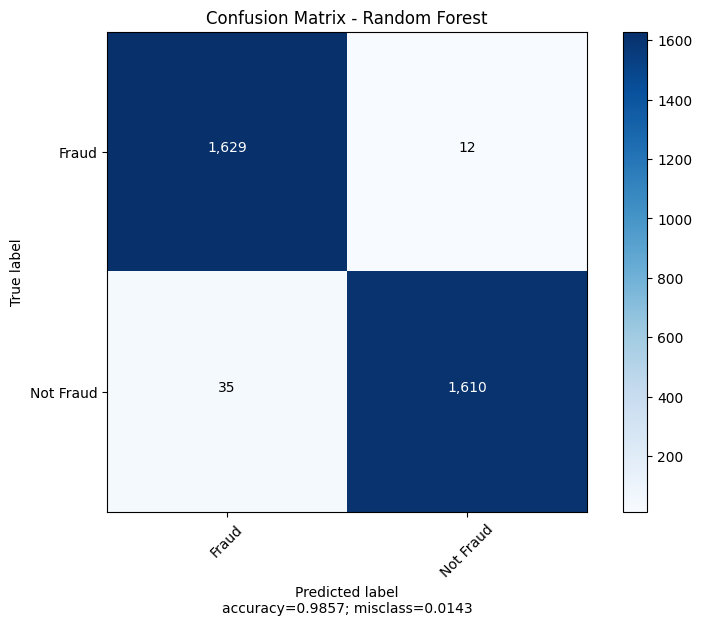

In [ ]:
plot_confusion_matrix(cm=confusion, target_names = ['Fraud', 'Not Fraud'], title = 'Confusion Matrix - Random Forest',normalize=False)

In [ ]:
# Let's calculate metrics:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
fbeta_precision = fbeta_score(y_test, predictions, beta=0.5)
fbeta_recall = fbeta_score(y_test, predictions, beta=2)

print('Accuracy score: {:.2f}'.format(accuracy))
print('Precision score: {:.2f}'.format(precision))
print('Recall score: {:.2f}'.format(recall))
print('F1 score: {:.2f}'.format(f1))
print('Fbeta score favoring precision: {:.2f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.2f}'.format(fbeta_recall))

Accuracy score: 0.89
Precision score: 0.87
Recall score: 0.91
F1 score: 0.89
Fbeta score favoring precision: 0.88
FBeta score favoring recall: 0.90


In [ ]:
report = classification_report(y_test, predictions, target_names=['Not Fraud', 'Fraud'])
print(report)

              precision    recall  f1-score   support

   Not Fraud       0.91      0.86      0.88      1645
       Fraud       0.87      0.91      0.89      1641

    accuracy                           0.89      3286
   macro avg       0.89      0.89      0.89      3286
weighted avg       0.89      0.89      0.89      3286



In [ ]:
mse_rf = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse_rf)

Mean Squared Error (MSE): 0.11442483262325015


We've got a very small mean squared error between the predicted values and the test ones, this indicates that the model is well calibrated.

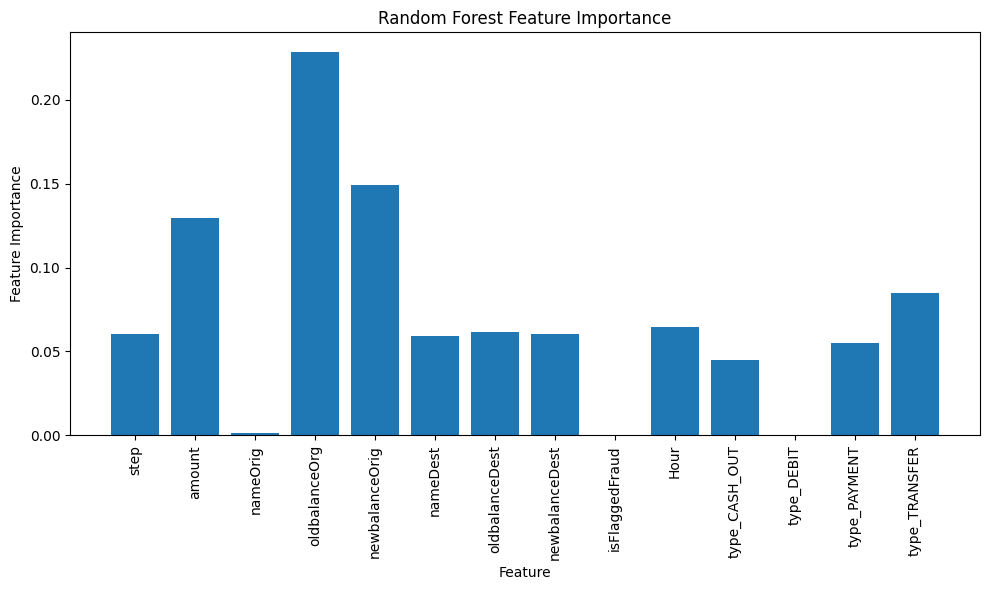

In [ ]:
# feature importance
plt.figure(figsize=(10, 6))

feature_importance = best_rfc_model.feature_importances_
feature_names = X.columns

plt.bar(range(len(feature_importance)), feature_importance, align="center")
plt.xticks(range(len(feature_importance)), feature_names, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

## Model 4: Support Vector Machine (linear classifier)

Support-vector machines (SVM) are another type of linear classifier. SVM attempts to construct a hyperplane (like a straight, 1D line in a 2D space), such that it separates the objects into classes, similarly to logistic regression. SVM, however, is concerned with finding the line that has the greatest distance to the nearest training data point.

SVM tends to perform well if the categories are linearly separable and there is clear separation between the classes. Overlap between the classes (or noise) tends to degrade performance. Although it is a memory-efficient algorithm, it tends to take a while—especially on large datasets.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, mean_squared_error

X = df_new_reduced.drop('isFraud', axis=1)
y = df_new_reduced['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 465)

# mean=0 and standard deviation=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

train_accuracy_svm = svm_model.score(X_train_scaled, y_train)
test_accuracy_svm = svm_model.score(X_test_scaled, y_test)

print("SVM Training Accuracy:", train_accuracy_svm)
print("SVM Test Accuracy:", test_accuracy_svm)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
print("SVM ROC AUC:", roc_auc_svm)
mse_svm = mean_squared_error(y_test, y_prob_svm)
print("SVM Mean Squared Error (MSE):", mse_svm)

SVM Training Accuracy: 0.9468036529680365
SVM Test Accuracy: 0.9482653682288497
SVM ROC AUC: 0.9904478513175856
SVM Mean Squared Error (MSE): 0.03758175219033848


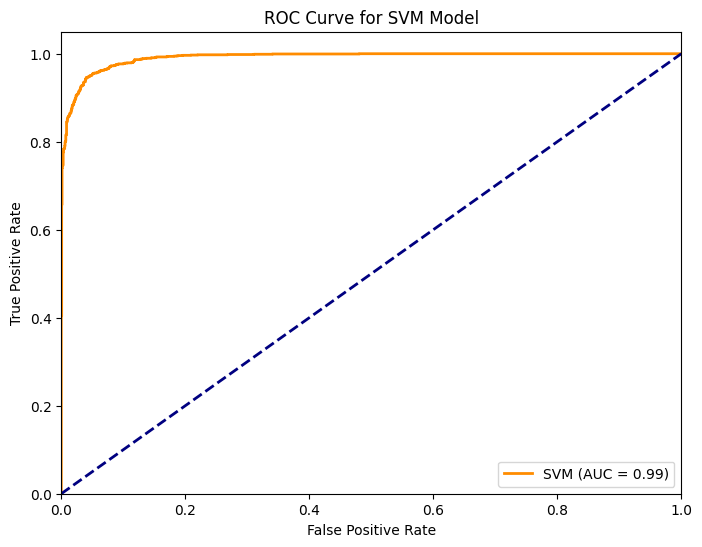

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='SVM (AUC = {:.2f})'.format(roc_auc_svm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Model')
plt.legend(loc='lower right')
plt.show()

## Model 5: Gradient Boosting (non linear classifier)

XGBoost is faster than sklearn gradientboosting.

Gradient Boost Training Accuracy: 0.9854642313546423
Gradient Boost Test Accuracy: 0.9860012172854534
Gradient Boost ROC AUC: 0.9977649109353959
Gradient Boost Mean Squared Error (MSE): 0.012921785561314049


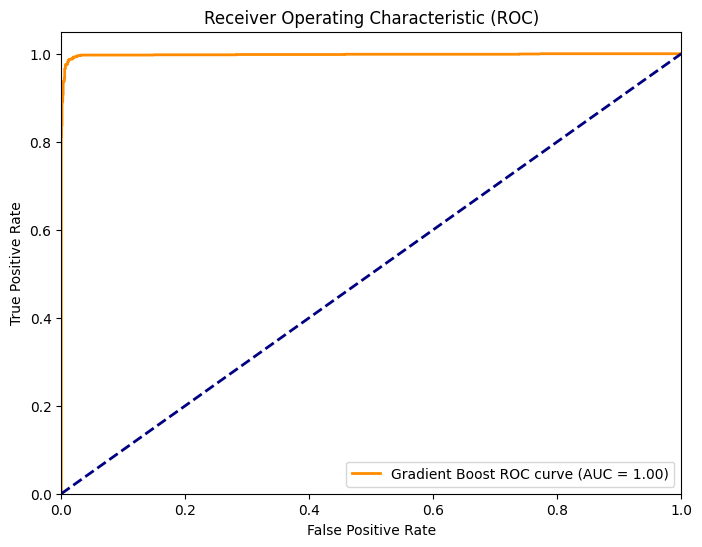

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import ensemble
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, mean_squared_error

X = df_new_reduced.drop('isFraud', axis=1)
y = df_new_reduced['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 465)

# mean=0 and standard deviation=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'log_loss',
          'learning_rate':0.1,
          'n_estimators':100
          }

# Initialize and fit the model.
clf_model = ensemble.GradientBoostingClassifier(**params)
clf_model.fit(X_train_scaled, y_train)

train_accuracy_clf = clf_model.score(X_train_scaled, y_train)
test_accuracy_clf = clf_model.score(X_test_scaled, y_test)

print("Gradient Boost Training Accuracy:", train_accuracy_clf)
print("Gradient Boost Test Accuracy:", test_accuracy_clf)

y_prob_clf = clf_model.predict_proba(X_test_scaled)[:, 1]

fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, y_prob_clf)
roc_auc_clf = auc(fpr_clf, tpr_clf)
print("Gradient Boost ROC AUC:", roc_auc_clf)

# Mean Squared Error (MSE)
mse_clf = mean_squared_error(y_test, y_prob_clf)
print("Gradient Boost Mean Squared Error (MSE):", mse_clf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_clf, tpr_clf, color='darkorange', lw=2, label='Gradient Boost ROC curve (AUC = {:.2f})'.format(roc_auc_clf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


# 4) Feature Importance

As the name describes, `Feature Importance` analysis tells us which feature(s) have the most impact in each ML model.

Logistic regression, KNN and SVM do not have built-in functions for feature importance. For Logistic Regression and SVM, we can find it by multiplying the standard deviation by the coefficients of each feature. Random Forest and Gradient Boosting have built-in feature importance functions.

In [ ]:
# Dataframe of X_train_scaled and X_test_scaled
df_X_train_std = pd.DataFrame(X_train_scaled, columns=X_train.columns)
df_X_test_std = pd.DataFrame(X_test_scaled, columns=X_test.columns)

### Logistic Regression

In [ ]:

embeded_lr_features_2 = df_X_train_std[df_X_train_std.columns.values]

tmp1 = []
tmp2 = []
for i in range(14):
    tmp1.append(logreg_model.coef_[:,i])
    tmp2.append(tmp1[i].mean())

lr_clfs_df = pd.DataFrame({'Feature name':abs(np.std(embeded_lr_features_2, 0) * tmp2).index, 'Importance': abs(np.std(embeded_lr_features_2, 0) * tmp2).values})
lr_clfs_df.sort_values(by='Importance', ascending=True, inplace= True)


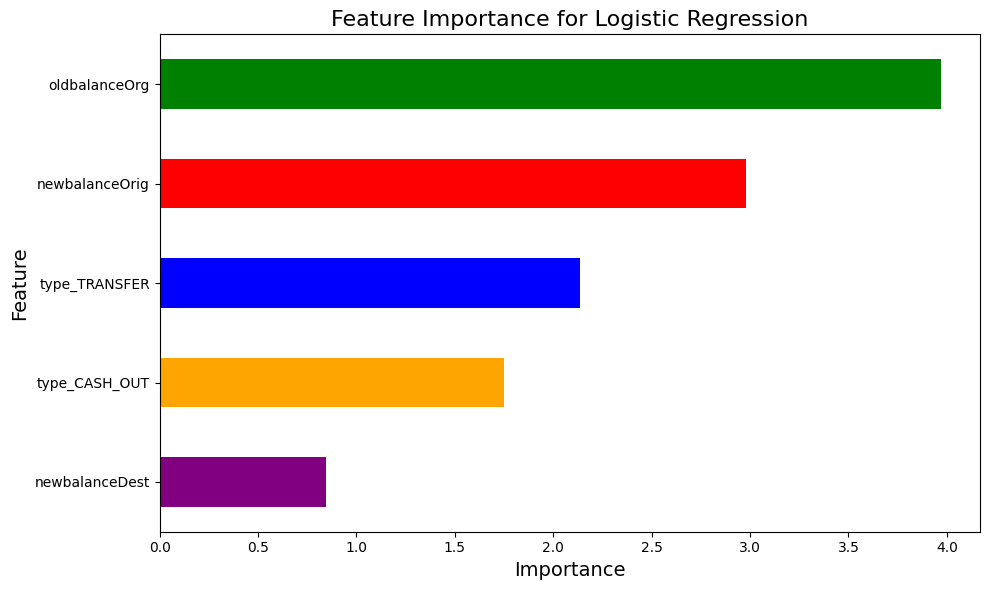

In [ ]:
# Plot top 5 features

lr_clfs_df[-5:].plot('Feature name', 'Importance', kind = 'barh',legend=False, color=['purple', 'orange', 'blue', 'red', 'green'],figsize=(10,6))
plt.title('Feature Importance for Logistic Regression', fontsize = 16)
plt.xlabel('Importance', fontsize = 14)
plt.ylabel('Feature', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

### Random Forest

In [ ]:
feature_importance_rf = best_rfc_model.feature_importances_
#feature_names_rf = X.columns

rf_clfs_underspld_df = pd.DataFrame({'Feature name' : df_X_train_std.columns, 'Importance' : feature_importance_rf})
rf_clfs_underspld_df.sort_values(by='Importance', ascending=True, inplace= True)

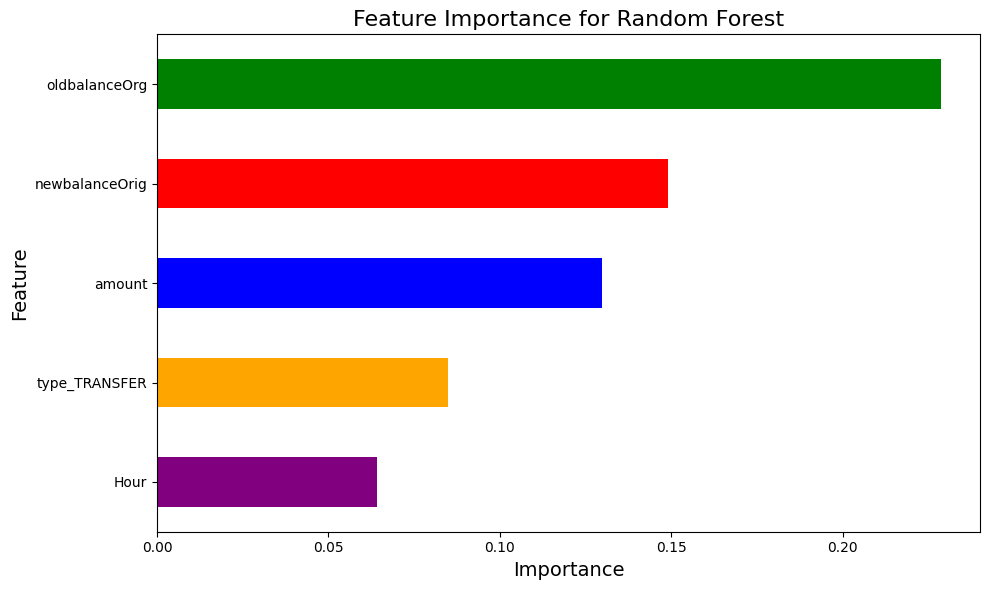

In [ ]:
# Plot top 5 features

rf_clfs_underspld_df[-5:].plot('Feature name', 'Importance', kind = 'barh',legend=False, color=['purple', 'orange', 'blue', 'red', 'green'],figsize=(10,6))
plt.title('Feature Importance for Random Forest', fontsize = 16)
plt.xlabel('Importance', fontsize = 14)
plt.ylabel('Feature', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

### Gradient Boosting

In [ ]:
lgbm_importance_underspld = clf_model.feature_importances_

lgbm_clfs_underspld_df = pd.DataFrame({'Feature name' : df_X_train_std.columns, 'Importance' : lgbm_importance_underspld/np.sum(lgbm_importance_underspld)})
lgbm_clfs_underspld_df.sort_values(by='Importance', ascending=True, inplace= True)

In [ ]:
# Plot top 5 features

lgbm_clfs_underspld_df[-5:].plot('Feature name', 'Importance', kind = 'barh',legend=False, color=['purple', 'orange', 'blue', 'red', 'green'],figsize=(10,6))
plt.title('Feature Importance for Gradient Boost', fontsize = 16)
plt.xlabel('Importance', fontsize = 14)
plt.ylabel('Feature', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

NameError: name 'lgbm_clfs_underspld_df' is not defined

### SVM

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(svm_model, X_test_scaled, y_test, n_repeats=30, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()[::-1]

for idx in sorted_idx:
    print(f"Feature {idx + 1}: {perm_importance.importances_mean[idx]:.4f}")


Feature 4: 0.3565
Feature 14: 0.1590
Feature 5: 0.1261
Feature 2: 0.0840
Feature 8: 0.0635
Feature 11: 0.0615
Feature 7: 0.0345
Feature 10: 0.0237
Feature 1: 0.0154
Feature 13: 0.0046
Feature 9: 0.0037
Feature 3: 0.0003
Feature 6: 0.0003
Feature 12: 0.0000


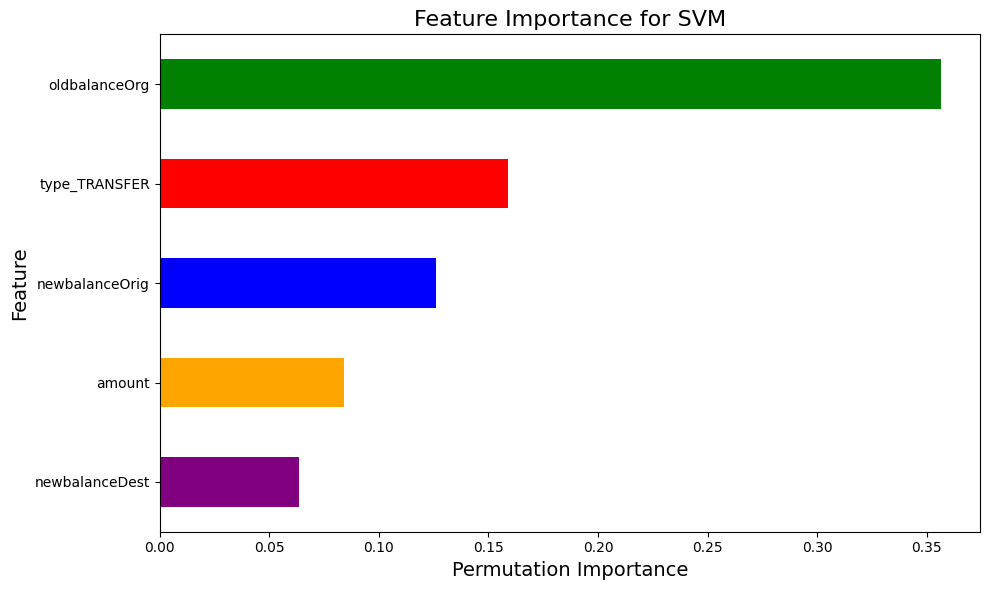

In [ ]:
# Plot top 5 features

features = [col for col in df_new_reduced.columns if col not in ['isFraud']]
features_sorted = [features[i] for i in sorted_idx]
importances = perm_importance.importances_mean[sorted_idx]

svm_df = pd.DataFrame({'Feature name':features_sorted, 'Importance': importances})
svm_df.sort_values(by='Importance', ascending=True, inplace= True)

#plt.figure(figsize=(10,6))
svm_df[-5:].plot('Feature name', 'Importance', kind = 'barh',legend=False, color=['purple', 'orange', 'blue', 'red', 'green'],figsize=(10,6))
#plt.barh(features_sorted[-5:], importances[-5:],color=['purple', 'orange', 'blue', 'red', 'green'],)#,figsize=(10,6))

plt.title('Feature Importance for SVM', fontsize = 16)
plt.xlabel('Permutation Importance', fontsize = 14)
plt.ylabel('Feature', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

# 5) Models Comparison

In [ ]:
# As a recap:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import ensemble


X = df_new_reduced.drop('isFraud', axis=1)
y = df_new_reduced['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 465)

# mean=0 and standard deviation=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models:
logreg_model = LogisticRegression(penalty='l2', C=0.05)
knn_model    = KNeighborsClassifier(n_neighbors = 10,weights='distance')
rfc_params = {'max_depth': 8,
              'min_samples_split': 5,
              'n_estimators': 100,
              'random_state': 42
              }
rfc_model    = RandomForestClassifier(**rfc_params)
svm_model    = SVC(kernel='linear', probability=True, random_state=42)
clf_params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'log_loss',
          'learning_rate':0.1,
          'n_estimators':100
          }
clf_model = ensemble.GradientBoostingClassifier(**clf_params)

model_names = {0: 'Logistic Regression', 1: 'KNN',2:'Random Forest',3:'SVC',4:'Gradient Boosting'}
models =[logreg_model,knn_model,rfc_model,svm_model,clf_model]


for i,model in enumerate(models):
    print("{} Training Accuracy: {}".format(model_names[i],cross_val_score(model, X_train_scaled, y_train, cv=10, scoring ='accuracy').mean()))
    print("{} Test Accuracy: {}".format(model_names[i],cross_val_score(model, X_test_scaled, y_test, cv=10, scoring ='accuracy').mean()))



Logistic Regression Training Accuracy: 0.8766362252663622
Logistic Regression Test Accuracy: 0.8609320557491289
KNN Training Accuracy: 0.9056316590563167
KNN Test Accuracy: 0.8904598191118689
Random Forest Training Accuracy: 0.9818112633181126
Random Forest Test Accuracy: 0.9808260434428053
SVC Training Accuracy: 0.9469558599695584
SVC Test Accuracy: 0.931540514493291
Gradient Boosting Training Accuracy: 0.9831050228310503
Gradient Boosting Test Accuracy: 0.9829546296982727


## Comparison:

1) ***Logistic Regression***
- Training accuracy: 0.8766
- Test accuracy: 0.8609
- MSE: 0.1125

2) ***KNN***
- Training accuracy: 0.9056
- Test accuracy: 0.8904
- MSE: 0.0937

3) ***Random Forest***
- Training accuracy: 0.9818
- Test accuracy: 0.9808
- MSE: 0.0143

4) ***SVM***
- Training accuracy: 0.9469
- Test accuracy: 0.9315
- MSE: 0.0365

4) ***Gradient Boosting***
- Training accuracy: 0.9831
- Test accuracy: 0.9829
- MSE: 0.0129

All these models have excellent performances. However, **Logistic Regression** is the one who performs the poorest (relatively speaking), and **Random Forest** is the best one, together with **Gradient Boosting**.